# Collecting Horse VS Humans Dataset

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-06-03 09:58:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.184.128, 2a00:1450:400c:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.184.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  83.3MB/s    in 1.7s    

2020-06-03 09:58:45 (83.3 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-06-03 09:58:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]

# Creating Training and Validation Directories

In [0]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

# Building a Seqential Model

In [3]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        1

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [7]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
8/8 [==============================] - 18s 2s/step - loss: 0.6951 - acc: 0.5261 - val_loss: 0.6940 - val_acc: 0.4922
Epoch 2/100
8/8 [==============================] - 21s 3s/step - loss: 0.7058 - acc: 0.4983 - val_loss: 0.6929 - val_acc: 0.6172
Epoch 3/100
8/8 [==============================] - 21s 3s/step - loss: 0.6854 - acc: 0.5651 - val_loss: 0.6906 - val_acc: 0.5156
Epoch 4/100
8/8 [==============================] - 21s 3s/step - loss: 0.6764 - acc: 0.5862 - val_loss: 0.6914 - val_acc: 0.5000
Epoch 5/100
8/8 [==============================] - 21s 3s/step - loss: 0.6839 - acc: 0.6029 - val_loss: 0.6896 - val_acc: 0.4961
Epoch 6/100
8/8 [==============================] - 21s 3s/step - loss: 0.6685 - acc: 0.5929 - val_loss: 0.6877 - val_acc: 0.5000
Epoch 7/100
8/8 [==============================] - 21s 3s/step - loss: 0.6644 - acc: 0.5907 - val_loss: 0.6887 - val_acc: 0.5000
Epoch 8/100
8/8 [====

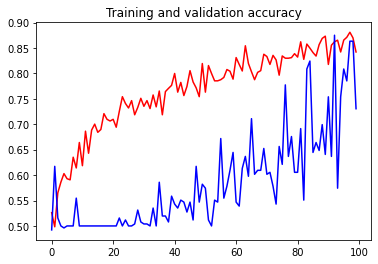

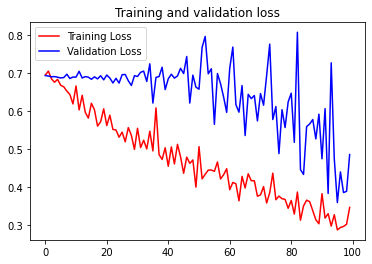

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
#Results Obtained from Custom CNN Network was Encouraging. Now we will experiment with AlexNet Architecture.

# Experimenting with AlexNet Architecture


In [9]:
model2 = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Conv2D(96, (11,11),strides = (4,4),activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((3,3), strides=(2,2)),

    tf.keras.layers.Conv2D(256, (5,5), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3), strides=(2,2)),

    tf.keras.layers.Conv2D(384, (3,3),padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(384, (3,3),padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3),padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3), strides=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 96)        34944     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 256)       614656    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 384)       885120    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 17, 384)       1327488   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 17, 17, 256)      

In [0]:
model2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
# Training the Model
history = model2.fit_generator(
      train_generator,
      steps_per_epoch=8,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=8,  # 1000 images = batch_size * steps
      verbose=2)

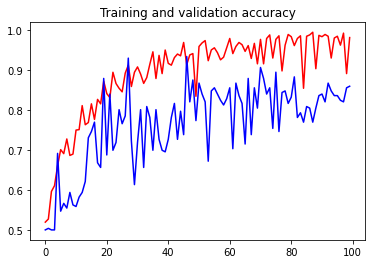

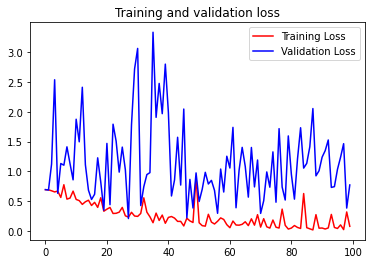

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()